<a href="https://colab.research.google.com/github/Mmengyw/Capstone-Updated/blob/main/SAR%2BCamera_Fusion/SAR_and_Camera_PointCloud_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Packages

In [1]:
# classic libraries
import matplotlib
import torch
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from math import *
from math import sin,cos,atan2 


# I/O libraries
import os
from io import BytesIO
import tarfile
import tempfile
from six.moves import urllib
import subprocess as subp
import pickle

#data analysis libraries
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import pandas as pd

#image processing libraries
import cv2 as cv
from google.colab.patches import cv2_imshow
from PIL import Image

# Tensorflow
import tensorflow.compat.v1 as tf
print(tf.__version__)

#others libraries
from tqdm import tqdm
import IPython
from tabulate import tabulate



# Comment this out if you want to see Deprecation warnings
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
#test

2.8.0


In [2]:
pip install timm

     |████████████████████████████████| 431 kB 5.3 MB/s 


# Loading our github

In [3]:
%cd /content/
!git clone https://github.com/Mmengyw/Capstone-Updated.git
!ls
os.chdir("Capstone-Updated/Videos")

/content
Cloning into 'Capstone-Updated'...
remote: Enumerating objects: 242, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 242 (delta 11), reused 14 (delta 6), pack-reused 222
Receiving objects: 100% (242/242), 217.29 MiB | 39.44 MiB/s, done.
Resolving deltas: 100% (126/126), done.
Capstone-Updated  sample_data


# Functions for Image Segmentation ???

### Class to load deeplab model and run inference


Definition of the class DeepLabModel


1.   function run: 

  *   Args: 
            - image: A PIL.Image object, raw input image.
            - INPUT_TENSOR_NAME: The name of input tensor, default to ImageTensor.
            - OUTPUT_TENSOR_NAME: The name of output tensor, default to SemanticPredictions.
  *   Returns: 
            - resized_image: RGB image resized from original input image.
            - seg_map: Segmentation map of `resized_image`.




In [4]:
class DeepLabModel(object):
    """Class to load deeplab model and run inference."""

    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    def __init__(self, tarball_path):
        """Creates and loads pretrained deeplab model."""
        self.graph = tf.Graph()
        graph_def = None

        # Extract frozen graph from tar archive.
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        if graph_def is None:
            raise RuntimeError('Cannot find inference graph in tar archive.')

        with self.graph.as_default():
            tf.import_graph_def(graph_def, name='')
        self.sess = tf.Session(graph=self.graph)

    def run(self, image, INPUT_TENSOR_NAME = 'ImageTensor:0', OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'):
        """Runs inference on a single image.

        Args:
            image: A PIL.Image object, raw input image.
            INPUT_TENSOR_NAME: The name of input tensor, default to ImageTensor.
            OUTPUT_TENSOR_NAME: The name of output tensor, default to SemanticPredictions.

        Returns:
            resized_image: RGB image resized from original input image.
            seg_map: Segmentation map of `resized_image`.
        """
        width, height = image.size
        target_size = (2049,1025)  # size of Cityscapes images
        resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
        batch_seg_map = self.sess.run(
            OUTPUT_TENSOR_NAME,
            feed_dict={INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
        seg_map = batch_seg_map[0]  # expected batch size = 1
        if len(seg_map.shape) == 2:
            seg_map = np.expand_dims(seg_map,-1)  # need an extra dimension for cv.resize
        seg_map = cv.resize(seg_map, (width,height), interpolation=cv.INTER_NEAREST)
        return seg_map

In [5]:
def create_label_colormap():
    """Creates a label colormap used in Cityscapes segmentation benchmark.

    Returns:
        A Colormap for visualizing segmentation results.
    """
    colormap = np.array([
        [128,  64, 128],
        [244,  35, 232],
        [ 70,  70,  70],
        [102, 102, 156],
        [190, 153, 153],
        [153, 153, 153],
        [250, 170,  30],
        [220, 220,   0],
        [107, 142,  35],
        [152, 251, 152],
        [ 70, 130, 180],
        [220,  20,  60],
        [255,   0,   0],
        [  0,   0, 142],
        [  0,   0,  70],
        [  0,  60, 100],
        [  0,  80, 100],
        [  0,   0, 230],
        [119,  11,  32],
        [  0,   0,   0]], dtype=np.uint8)
    return colormap


def label_to_color_image(label):
    """Adds color defined by the dataset colormap to the label.

    Args:
        label: A 2D array with integer type, storing the segmentation label.

    Returns:
        result: A 2D array with floating type. The element of the array
            is the color indexed by the corresponding element in the input label
            to the PASCAL color map.

    Raises:
        ValueError: If label is not of rank 2 or its value is larger than color
            map maximum entry.
    """
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    colormap = create_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]


def vis_segmentation(image, seg_map):
    """Visualizes input image, segmentation map and overlay view."""
    plt.figure(figsize=(20, 4))
    grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

    plt.subplot(grid_spec[0])
    plt.imshow(image)
    plt.axis('off')
    plt.title('input image')

    plt.subplot(grid_spec[1])
    seg_image = label_to_color_image(seg_map).astype(np.uint8)
    plt.imshow(seg_image)
    plt.axis('off')
    plt.title('segmentation map')

    plt.subplot(grid_spec[2])
    plt.imshow(image)
    plt.imshow(seg_image, alpha=0.7)
    plt.axis('off')
    plt.title('segmentation overlay')

    unique_labels = np.unique(seg_map)
    ax = plt.subplot(grid_spec[3])
    plt.imshow(FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
    ax.yaxis.tick_right()
    plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
    plt.xticks([], [])
    ax.tick_params(width=0.0)
    plt.grid('off')
    plt.show()


LABEL_NAMES = np.asarray([
    'road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic light',
    'traffic sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck',
    'bus', 'train', 'motorcycle', 'bicycle', 'void'])

COLOR_MAP = np.array([
    [128,  64, 128],
    [244,  35, 232],
    [ 70,  70,  70],
    [102, 102, 156],
    [190, 153, 153],
    [153, 153, 153],
    [250, 170,  30],
    [220, 220,   0],
    [107, 142,  35],
    [152, 251, 152],
    [ 70, 130, 180],
    [220,  20,  60],
    [255,   0,   0],
    [  0,   0, 142],
    [  0,   0,  70],
    [  0,  60, 100],
    [  0,  80, 100],
    [  0,   0, 230],
    [119,  11,  32],
    [  0,   0,   0]], dtype=np.uint8)

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

In [6]:
MODEL_NAME = 'mobilenetv2_coco_cityscapes_trainfine'
#MODEL_NAME = 'xception65_cityscapes_trainfine'

_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'
_MODEL_URLS = {
    'mobilenetv2_coco_cityscapes_trainfine':
        'deeplabv3_mnv2_cityscapes_train_2018_02_05.tar.gz',
    'xception65_cityscapes_trainfine':
        'deeplabv3_cityscapes_train_2018_02_06.tar.gz',
}
_TARBALL_NAME = 'deeplab_model.tar.gz'

model_dir = tempfile.mkdtemp()
tf.gfile.MakeDirs(model_dir)

download_path = os.path.join(model_dir, _TARBALL_NAME)
print('downloading model, this might take a while...')
urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + _MODEL_URLS[MODEL_NAME], download_path)
print('download completed! loading DeepLab model...')

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

downloading model, this might take a while...
download completed! loading DeepLab model...
model loaded successfully!


# Initialize Midas

In [7]:
%cd /content/
model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
#model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
#model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)

midas = torch.hub.load("intel-isl/MiDaS", model_type)

/content


Downloading: "https://github.com/intel-isl/MiDaS/archive/master.zip" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/intel-isl/DPT/releases/download/1_0/dpt_large-midas-2f21e586.pt" to /root/.cache/torch/hub/checkpoints/dpt_large-midas-2f21e586.pt


  0%|          | 0.00/1.28G [00:00<?, ?B/s]

In [8]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()

DPTDepthModel(
  (pretrained): Module(
    (model): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=1024, out_features=1024, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (drop_path): Identity()
          (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=1024, out_features=4096, bias=True)
            (act): GELU()
            (drop1): Dropout(p=0.0, inplace=False)
            (fc2): Linear(in_features=4

In [9]:
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


In [10]:
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


# Boosted Midas


In [ ]:
!cd /content/
# Clone git repo
!git clone https://github.com/compphoto/BoostingMonocularDepth.git

!wget https://sfu.ca/~yagiz/CVPR21/latest_net_G.pth
#!gdown https://drive.google.com/u/0/uc?id=1cU2y-kMbt0Sf00Ns4CN2oO9qPJ8BensP&export=download

# Downloading merge model weights
!mkdir -p /content/BoostingMonocularDepth/pix2pix/checkpoints/mergemodel/
!mv latest_net_G.pth /content/BoostingMonocularDepth/pix2pix/checkpoints/mergemodel/

# Downloading Midas weights
!wget https://github.com/AlexeyAB/MiDaS/releases/download/midas_dpt/midas_v21-f6b98070.pt
!mv midas_v21-f6b98070.pt /content/BoostingMonocularDepth/midas/model.pt

# # Downloading LeRes weights
!wget https://cloudstor.aarnet.edu.au/plus/s/lTIJF4vrvHCAI31/download
!mv download /content/BoostingMonocularDepth/res101.pth

#creation of useful folders to run boosted midas
!cd /content/
!mkdir '/content/Depth_pred_folder/'
!mkdir '/content/Depth_pred_folder/inputs/'
!mkdir '/content/Depth_pred_folder/outputs/'

!cd /content

fatal: destination path 'BoostingMonocularDepth' already exists and is not an empty directory.
--2022-04-20 16:42:43--  https://sfu.ca/~yagiz/CVPR21/latest_net_G.pth
Resolving sfu.ca (sfu.ca)... 142.58.228.150, 142.58.103.17, 142.58.103.137, ...
Connecting to sfu.ca (sfu.ca)|142.58.228.150|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.sfu.ca/~yagiz/CVPR21/latest_net_G.pth [following]
--2022-04-20 16:42:43--  https://www.sfu.ca/~yagiz/CVPR21/latest_net_G.pth
Resolving www.sfu.ca (www.sfu.ca)... 142.58.228.150
Connecting to www.sfu.ca (www.sfu.ca)|142.58.228.150|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 318268048 (304M)
Saving to: ‘latest_net_G.pth’

latest_net_G.pth    100%[===================>] 303.52M  14.1MB/s    in 21s     

2022-04-20 16:43:05 (14.4 MB/s) - ‘latest_net_G.pth’ saved [318268048/318268048]

--2022-04-20 16:43:05--  https://github.com/AlexeyAB/MiDaS/releases/download/midas_dpt/mida

In [ ]:
#gray scale results
%cd /content/BoostingMonocularDepth/
!python run.py --Final --data_dir /content/Depth_pred_folder/inputs/ --output_dir  /content/Depth_pred_folder/outputs/ --depthNet 2

/content/BoostingMonocularDepth
python3: can't open file 'run.py': [Errno 2] No such file or directory


Depth prediction on 1 frame

In [ ]:
#path of our video
dir_video = '/content/Capstone-Updated/Videos/camera30fps.mp4'


#put video in a variable
video_cam_car = cv.VideoCapture(str(dir_video))
ret, first_frame = video_cam_car.read()   #first frame is numpy array

#number of frames of the video
num_frames = 1000
nb_row,nb_col,rgb = np.shape(first_frame)


#empty these folders just in case they already exist and are not empty
dir = '/content/Depth_pred_folder/inputs/'
for f in os.listdir(dir):     #delete all files in the directory dir
    os.remove(os.path.join(dir, f))

dir = '/content/Depth_pred_folder/outputs/'
for f in os.listdir(dir):     #delete all files in the directory dir
    os.remove(os.path.join(dir, f))

for k in range(0,num_frames):
  _, frame_k = video_cam_car.read()   #read video

##########################  run on the frame_k
rgb_map_all_frames = frame_k   #fill the rgb map


#saving the frame k as an image png
frame_k_file = Image.fromarray(frame_k) #frame k is a np.array
frame_k_file.save('/content/Depth_pred_folder/inputs/frame_k.png')

# uncomment to run the segmentation code and fill the seg map
#seg_map_all_frames[i] = MODEL.run(frame_k_file)

### run boosted midas ###
%cd /content/BoostingMonocularDepth/
!python run.py --Final --data_dir /content/Depth_pred_folder/inputs/ --output_dir /content/Depth_pred_folder/outputs --depthNet 2

%cd /content/
#depth_im = Image.open('/content/Depth_pred_folder/outputs/frame_k.png') 

#depth_map_frame_k = np.array(depth_im)

/content/BoostingMonocularDepth
python3: can't open file 'run.py': [Errno 2] No such file or directory
/content


In [ ]:
def boosted_midas(frame_k):   #run boosted midas on the frame_k and return a np.array depth map
    #saving the frame k as an image png
    frame_k_file = Image.fromarray(frame_k) #frame k is a np.array
    frame_k_file.save('/content/Depth_pred_folder/inputs/frame_k.png')

    ### run boosted midas ###
    subp.call('cd /content/BoostingMonocularDepth/', shell=True)
    call_args = 'python run.py --Final --data_dir /content/Depth_pred_folder/inputs/ --output_dir /content/Depth_pred_folder/outputs/ --depthNet 2'
    call_args = call_args.split() # because call takes a list of strings 
    subp.call(call_args)

    depth_im = Image.open('/content/Depth_pred_folder/outputs/frame_k.png') 

    depth_im = np.array(depth_im)

    print(np.shape(depth_im))

    
    return np.array(depth_im)

# Depth Pred Improvement

In [11]:
def get_depth_map_midas(frame_k):

    img_k = frame_k
    img_k = cv.cvtColor(img_k, cv.COLOR_BGR2RGB)

    input_batch = transform(img_k).to(device)

    with torch.no_grad():
      prediction = midas(input_batch)

      prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img_k.shape[:2],
        mode="bicubic",
        align_corners=False,
      ).squeeze()
    
    # ''' added from the leres github use of simple midas
    prediction = prediction.squeeze().cpu().numpy()
    prediction = cv.resize(prediction, (img_k.shape[1], img_k.shape[0]), interpolation=cv.INTER_CUBIC)

    # Normalization
    depth_min = prediction.min()
    depth_max = prediction.max()

    if depth_max - depth_min > np.finfo("float").eps:
        prediction = (prediction - depth_min) / (depth_max - depth_min)
    else:
        prediction = 0
    # '''

    output = prediction
    output = (output > 0) * output
    distanceGuess = 2
    alpha = output[output.shape[0]-10, int(output.shape[1]*3/4)]*distanceGuess
    output = alpha/(output+.001)

    return output

In [12]:
# Get the data of the movement of the car
%cd /content/Capstone-Updated/Videos

SAR_tracklog = pd.read_pickle('sar_tracklog.pickle')

SAR_tracklog = np.array(SAR_tracklog)

/content/Capstone-Updated/Videos


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


## Kalman Filter

In [13]:
#guess the position k+1 of all object using the movement of the car
def guess_pos_map_car_k1(Pos_map_midas_k, Camref_k, Camref_k1):  #return the entire the position for  
    nb_row, nb_col, rgb = np.shape(Pos_map_midas_k)
    Pos_map_car_k1 = np.zeros((nb_row, nb_col, rgb))

    tk, Rk, Tk = Camref_k
    print(Camref_k)
    tk1, Rk1, Tk1 = Camref_k1
    print(Camref_k1)
    dRk1 = (Rk.T)@Rk1    #change to Camref_k frame
    dTk1 = (Rk.T)@(Tk1 - Tk) #change to Camref_k frame

    for i in range(nb_row):
      for j in range(nb_col): 
        print(np.shape(Pos_map_car_k1[i,j]))
        print(Pos_map_car_k1[i,j])
        print(np.shape(Pos_map_midas_k[i,j]))
        print(Pos_map_midas_k[i,j])
        print(dRk1.T)
        print(dTk1)
        Pos_map_car_k1[i,j] = (dRk1.T)@(Pos_map_midas_k[i,j] - dTk1)
    return Pos_map_car_k1


def Kalman_Filter_k1_mean(predicted_depth_k1, measured_depth_k1):
  nb_row, nb_col = np.shape(predicted_depth_k1)
  adjusted_depth = np.empty((nb_row,nb_col)) 
  adjusted_depth = (predicted_depth_k1 + measured_depth_k1)/2
  return adjusted_depth
  
def Improve_pos_1_frame(k, SAR_tracklog,pos_map_k, pos_map_k1):
  Camref_k = SAR_tracklog[k]
  Camref_k1 = SAR_tracklog[k+1]
  #print('pos_map_k',pos_map_k)
  predicted_pos_k1 = guess_pos_map_car_k1(pos_map_k, Camref_k, Camref_k1)
  #print('predicted_pos_k1',predicted_pos_k1)
  measured_pos_k1 = pos_map_k1
  
  adjusted_pos_map_k1 = Kalman_Filter_k1_mean(predicted_pos_k1, measured_pos_k1)

  return adjusted_pos_map_k1

# Convert Camera Frame to SAR frame

In [14]:
#Transform a point [X,Y,Z] from the camera frame to the car frame (SAR)
def Cam_ref_2_Car_ref(Pos_obj_cam):
    #camera extrinsic (quaternion, translation)
    R = np.array([[ 0.99994752,  0.00325207,  0.00971481],
                  [-0.0030831 ,  0.99984459, -0.01735761],
                  [-0.00976975,  0.01732675,  0.99980215]])

    T = np.array([-0.41649988293647766, 0.09146018326282501, 0.011436160653829575])

    Pos_obj_cam = np.array(Pos_obj_cam)

    Pos_obj_car = R@Pos_obj_cam[:3] + T
    Pos_obj_car = np.append(Pos_obj_car,[Pos_obj_cam[-1]])
    return Pos_obj_car

# Conversion to meters

### Experimental Data
stored it in a pickle file

In [15]:
# DATA from the experiments

equiv=[[0,200],    #for extrapolation
      [0.001,51],    #for extrapolation
      [0.1,45],     #premier plan
      [0.9,42.3],
      [1.8,37.4],
      [2.7,28.7],
      [3.6,24.443365],
      [4.5,22.058018],
      [5.4,15.317413],
      [6.3,14.677493],
      [7.2,10.969739],
      [8.1,10.883035],
      [9,9.883035],
      [9.9,8.058806],
      [10.8,7.5158963],
      [11.7,7.098169],
      [12.6,6.111024],
      [13.5,5.6323136],
      [14.4,5.2216917],
      [15.3,5],
      [16.2,4.9529667],
      [17.1,4.8],
      [18,4.7],
      [18.9,4.6],
      [19.8,4.5],
      [20.7,4.4],
      [21.6,4.3],
      [22.5,4.2],
      [23.4,4.1],
      [24.3,4],
      [25.2,3.9],
      [26.1,3.8],
      [27,3.7],
      [27.9,3.6],
      [28.8,3.5],
      [29.7,3.2],
      [30.6,3],
      [40,1.98],
      [50,1.33],
      [60,0.0], #horizon
       
      [120,-20]    #horizon extended
       
       ]   #for extrapolation

#=========================================================================================

equiv2=[[1,41.05157], #1yard  0302
        [1,42.18351],
        [1,31.304607],
        [1,25.090006],
        [1,23.275448], #5yard 0306
        [1,19.171278],
        [1,17.472866],
        [1,16.775742],
        [1,15.820402],
        [1,15.538459], #10yard  0311
        [1,14.466544],
        [1,12.707126],
        [1,10.957558],
      

        [1,6.023936],#'''inacurrate'''
        [1,9.797453],  #15yard 0316
        [1,7.2150397],
        [1,6.3944836],
        [1,8.514687],
        [1,7.735209],
        ]
for i in range(len(equiv2)):
  equiv2[i][0]*=(i+1)*0.9144   #1 yard = 0.9144 m

equiv=equiv+equiv2

# take second element for sort
def takeSecond(elem):
    return elem[1]
# sort list with key
equiv.sort(key=takeSecond)

In [16]:
#create pickle file to store the measurements 
file_name="data_midas_2_meter_0.pkl"
df_data_exp = pd.DataFrame(data=equiv, columns=['Meters', 'Midas Values'])
df_data_exp.to_pickle(file_name)

### Conv function
use polynomial of 10deg regression

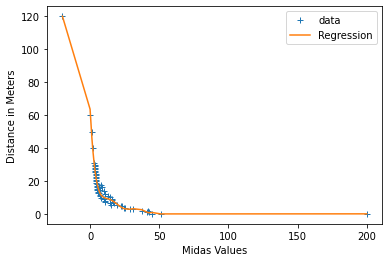

In [17]:
#read pickle file of the experimental measurements
file_name="data_midas_2_meter_0.pkl"
df2 = pd.read_pickle(file_name)
X_conv_2_mt = df2['Midas Values'].to_numpy()
Y_conv_2_mt = df2['Meters'].to_numpy()


conv = np.poly1d(np.polyfit(X_conv_2_mt, Y_conv_2_mt, 10))


plt.plot(X_conv_2_mt, Y_conv_2_mt, '+', X_conv_2_mt, conv(X_conv_2_mt), '-')
plt.xlabel('Midas Values') 
plt.ylabel('Distance in Meters') 
plt.legend(['data', 'Regression'], loc = 'best')

plt.show()

### Error of exp data


In [18]:
#code to determine the mean of the error and the variance of the error
def Mean_Var_exp(X,Y):
  Var_err_exp = 0
  Mean_err_exp = 0
  nb_points = len(X)
  for i in range(nb_points):
    Mean_err_exp += (Y[i]-conv(X[i]))/ nb_points
  for i in range(nb_points):
    Var_err_exp += (Y[i]-conv(X[i])-Mean_err_exp)**2/ nb_points
  return Mean_err_exp, Var_err_exp
Mean_Var_exp(X_conv_2_mt,Y_conv_2_mt)

(6.861916456595152e-08, 4.007766522662304)

# Segmented Point Cloud

In [19]:
#return the map of distances [X,Y,Z] for each pixel for certain object using the midas + segmentation maps
def depth2pcd_segm(depth,seg_map):
    # print(depth)
    # print(seg_map)
    width = depth.shape[1]
    height = depth.shape[0]
    # print(width)
    # print(height)
    fx= 926.9796142578125
    fy= 924.431884765625
    cx= 790.234375
    cy= 617.5499267578125
    points = []
    objects_needed = {'road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic light',
    'traffic sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck',
    'bus', 'train', 'motorcycle', 'bicycle', 'void'}
    objects_car = {'car','sidewalk'}
    objects_wanted = {'car', 'vegetation','sidewalk','fence'}


    for v in range(0, width, 5):
        for u in range(0, 1000, 5):
            R = depth[u][v]
            color = seg_map[u][v]

            if R == 0:
                continue

            if LABEL_NAMES[color] in objects_car:
                X_cam = (v - cx)
                Y_cam = -(u - cy)

                theta_x = atan2(X_cam,fx)
                theta_y = atan2(Y_cam,fy)

                X = R*cos(theta_y)*sin(theta_x)
                Y = R*cos(theta_x)*sin(theta_y)
                Z = R*cos(theta_x)*cos(theta_y)
                points.append(Cam_ref_2_Car_ref([X, Y, Z,color]))

    pcd_segm_car = points

    return pcd_segm_car

In [20]:
def prediction_stream_KF(num_frame, seg_map, prev_pc_3d_segmented, curr_frame): # previously (original_im, seg_map, frame, seg_data, index)
    """Visualizes segmentation overlay view and stream it with IPython display."""
    # for i in range(len(seg_map)):
    #     for j in range(len(seg_map[i])):
    #             seg_data[i][j] = LABEL_NAMES[seg_map[i][j]]
    
    curr_depth_map = get_depth_map_midas(curr_frame)
    
    curr_pc_3d_segmented = depth2pcd_segm(curr_depth_map,seg_map)   #from the car ref

    adjusted_pc_3d_segmented = Improve_pos_1_frame(num_frame, SAR_tracklog,prev_pc_3d_segmented, curr_pc_3d_segmented)

    return adjusted_pc_3d_segmented


def prediction_video(num_frame, prev_pc_3d_segmented, curr_frame): # previously (frame,index)
    """Inferences DeepLab model on a video file and stream the visualization."""
    original_im = Image.fromarray(curr_frame[..., ::-1])
    seg_map = MODEL.run(original_im)
    #seg_data = np.full((len(seg_map),len(seg_map[0])),'nullvoidnada')
    pc_3d_segmented = prediction_stream_KF(num_frame, seg_map, prev_pc_3d_segmented, curr_frame) #previously (original_im, seg_map, frame, seg_data, index)
    # print(filled_seg_data)
    return pc_3d_segmented

In [21]:
# Get Map of Time frames of SAR to Camera, by finding nearest frames

import pickle
%cd /content/Capstone-Updated/SAR+Camera_Fusion

with open('camera_times.pickle', 'rb') as file:
    camera_times = pickle.load(file)
%cd /content/Capstone-Updated/Videos

with open('sar_tracklog.pickle', 'rb') as file:
    SAR_tracklog = pickle.load(file)

SAR_tracklog = np.array(SAR_tracklog)
SAR_times = SAR_tracklog[:,0]

timestamp_map = np.zeros(len(SAR_times))

j=0
for i in range(len(SAR_times)):
  while camera_times[j]<SAR_times[i]:
    j+=1
  timestamp_map[i] = j
# print(timestamp_map)

/content/Capstone-Updated/SAR+Camera_Fusion
/content/Capstone-Updated/Videos


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  del sys.path[0]


# SAR Video Processing

In [22]:
%cd /content/Capstone-Updated/Videos

RADAR_VIDEO = 'radar_sar.mp4'
CAMERA_VIDEO = 'camera.mp4'

/content/Capstone-Updated/Videos


In [23]:
def Convert_to_Meters(frame):
  center_x = 625
  center_y = 624
  height, width = frame.shape

  points = []

  for v in range(0, width):
        for u in range(0, height):
          if frame[u][v]<200:
            x = (v-center_x)*0.04
            y = -(u-center_y)*0.04
            points.append([x,y])
  return np.array(points)

In [24]:
#Threshold the SAR pointcloud
def GetThreshold_Binary(frame):
  gray_scale = 255 - cv.cvtColor(frame,cv.COLOR_RGB2GRAY)
  threshold = 0.9*np.max(gray_scale)
  _, thres = cv.threshold(gray_scale, threshold, 255,cv.THRESH_BINARY)
  point_cloud = Convert_to_Meters(thres)
  point_cloud = np.array(point_cloud)
  return point_cloud

In [25]:
def Plot_Camera_with_SAR(point_cloud_SAR, point_cloud_Camera):
  
  fig = plt.figure(figsize=(12,6))
  plt.scatter(point_cloud_SAR[:,0],point_cloud_SAR[:,1],s=0.1, color = 'black')

  if len(point_cloud_Camera)>0:
    color = (point_cloud_Camera[:, 3])
    color_plot = np.array([COLOR_MAP[int(c)] for c in color])
    # print(color_plot)
    plt.scatter(point_cloud_Camera[:,0],point_cloud_Camera[:,2],s=0.1 , color = color_plot/255)
  plt.xlabel('X')
  plt.ylabel('Depth Z')
  plt.xlim(-25, 25)
  plt.ylim(0, 25) 

  plt.savefig('saved_figure.jpg')
  im = cv.imread('saved_figure.jpg')
  frames.append(im)
  plt.close()
  return

# Clustering

### Camera Clustering

In [26]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

def cluster_camera_pc(points_camera):    
    
    LABEL_NAMES = np.asarray([
    'road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic light',
    'traffic sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck',
    'bus', 'train', 'motorcycle', 'bicycle', 'void'])

    #transform a 4D camera PC in a dict of class with a 2D pc for each class
    class_list = np.unique(points_camera[:,-1])
    pc2d_camera_class = {}
    pc2d_camera_class_cluster = {}
    core_samples_mask = {}
    labels_clusters = {}

    for classe in class_list:   #create list/dict to contain the points of each class
        pc2d_camera_class[LABEL_NAMES[int(classe)]] = []
        core_samples_mask[LABEL_NAMES[int(classe)]] = []
        labels_clusters[LABEL_NAMES[int(classe)]] = []
        pc2d_camera_class_cluster[LABEL_NAMES[int(classe)]] = {}

    for point in points_camera:   #fill the list of the classified pc
        pc2d_camera_class[LABEL_NAMES[int(point[-1])]] += [[point[0],point[2]]]   #add only X and Z to create a 2D pc 



    # Compute DBSCAN for each class: eps = min distance between 2 clusters, min_samples = min of samples
    for classe in pc2d_camera_class:
        if classe == 'car':
            pc2d_camera_class_cluster[classe] = cluster_cam_car(0.5, 0, pc2d_camera_class, classe)
 
    print('all classes')
    AG_Plot_Camera_Clustering(pc2d_camera_class_cluster)

    print('just cars')
    pc_car_cluster = {'car': pc2d_camera_class_cluster['car']}
    AG_Plot_Camera_Clustering(pc_car_cluster)


    final_pc_car_cluster = {}
    print('filtered cars')
    pc_car_cluster_list = filter_car_noise(pc2d_camera_class_cluster)
    final_pc_car_cluster['car'] = pc_car_cluster_list
    #pc_car_cluster['car'] = final_pc_car_cluster['car']['points']
    #AG_Plot_Camera_Clustering(pc_car_cluster)
    
    return final_pc_car_cluster
    #return a dict with : #"classe": "cluster": {"centroid":[5,5], 'lim_points'[x_max,z_max] : [2.3,1.2], "points":[...]}






                    #eps = min distance between 2 clusters, min_samples = min of samples
def cluster_cam_car(eps_class, min_samples_class, pc2d_camera_class, classe):  
    db = DBSCAN(eps=eps_class, min_samples=min_samples_class).fit(pc2d_camera_class[classe])
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels_clusters = db.labels_
    cluster_list = np.unique(labels_clusters)
    np.delete(cluster_list,-1)    #remove the noise label

    pc2d_cam_cluster4class = {}

    print('for the class ', classe,' we have these clusters:', cluster_list)
    for object_cluster in cluster_list:   #create list to contain the points of each cluster of each class
        pc2d_cam_cluster4class[object_cluster] = []

    for i in range(len(pc2d_camera_class[classe])):  #fill the list of the classified and clustered pc
      if labels_clusters[i] != -1:        #do not take into account the noisy points
          pc2d_cam_cluster4class[labels_clusters[i]] += [pc2d_camera_class[classe][i]]
    
    return pc2d_cam_cluster4class


def filter_car_noise(pc2d_camera_class_cluster):
    pc_car_cluster = pc2d_camera_class_cluster['car']
    x_max_limit = 3 #3 meters between the centroid and the furthest point on the x axis
    z_max_limit = 2 #2 meters between the centroid and the furthest point on the z axis
    max_outsider = 0.1    #percentage of outsiders allowed
    x_min_limit = 1
    z_min_limit = 0.5
    new_pc_car_cluster = {}
    for cluster in pc_car_cluster:
        list_test = good_car_size(pc_car_cluster[cluster], x_max_limit, z_max_limit, x_min_limit, z_min_limit, max_outsider)
        if list_test[0]:
            new_pc_car_cluster[cluster] = {'centroid': list_test[1], 'lim_points': list_test[2], 'points': pc_car_cluster[cluster]}

    return new_pc_car_cluster


def good_car_size(cluster, x_max_limit, z_max_limit, x_min_limit, z_min_limit, max_outsider):
    cluster = np.asarray(cluster)
    centroid = np.mean(cluster, axis=0)

    lim_points = [0,0]

    xc = centroid[0]   #x coordinate of the centroid of the cluster
    zc = centroid[1]   #same for the z coordinate

    nb_outsiders_max = 0
    nb_outsiders_min = 0
    for points in cluster:  
      xp = points[0]
      zp = points[1]
      if abs(xc-xp) >= x_max_limit or abs(zc-zp) >= z_max_limit:
          nb_outsiders_max +=1
      if abs(xc-xp) <= x_min_limit and abs(zc-zp) <= z_min_limit: 
          nb_outsiders_min +=1

    if nb_outsiders_max/len(cluster) >= max_outsider:   #the rate of points outside the normal size of a car is too high
        return [False, centroid, lim_points]
    if nb_outsiders_min/len(cluster) >= (1-max_outsider):   #the rate of points outside the normal size of a car is too high
        return [False, centroid, lim_points]
    else:
        for points in cluster:
            xp = points[0]
            zp = points[1]
            if abs(xc-xp) >= lim_points[0]:
              lim_points[0] = abs(xc-xp)
            if abs(zc-zp) >= lim_points[1]:
              lim_points[1] = abs(zc-zp)

        return [True, centroid, lim_points]


####################################################################################
####################################################################################
####################################################################################


def AG_Plot_Camera_Clustering(pc2d_camera_class_cluster):
    for classe in pc2d_camera_class_cluster:
        for cluster in pc2d_camera_class_cluster[classe]:
            cluster_points = np.asarray(pc2d_camera_class_cluster[classe][cluster])
            X = cluster_points[:,0]
            Y = cluster_points[:,1]
            plt.plot(X,Y)
    plt.show()


def Plot_Camera_Clustering(pc2d_camera_class, core_samples_mask, labels):
    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print("Estimated number of clusters: %d" % n_clusters_)
    print("Estimated number of noise points: %d" % n_noise_)
    # for classe in pc2d_camera_class:
    print(pc2d_camera_class)
    print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(pc2d_camera_class, labels))

    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = labels == k
        
        pc2d_camera_class = np.array(pc2d_camera_class)
        xy = pc2d_camera_class[class_member_mask & core_samples_mask]
        # xy = []
        # for i in range(len(class_member_mask)):
        #   if class_member_mask[i] and core_samples_mask[i]:
        #       xy += [pc2d_camera_class[i]]
        plt.plot(xy[:, 0],xy[:, 1])#"o",markerfacecolor=tuple(col),markeredgecolor="k",markersize=14)

        xy = pc2d_camera_class[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0],xy[:, 1])#"o",markerfacecolor=tuple(col),markeredgecolor="k",markersize=6)


    plt.title("Estimated number of clusters: %d" % n_clusters_)
    plt.show()

In [27]:
cluster_camera_pc(points_camera)

NameError: ignored

### SAR clustering


In [ ]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

def cluster_SAR_pc(points_SAR):    

    # Compute DBSCAN: eps = min distance between 2 clusters, min_samples = min of samples
    db = DBSCAN(eps=0.5, min_samples=10).fit(points_SAR)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels_clusters = db.labels_
    cluster_list = np.unique(labels_clusters)
    np.delete(cluster_list, -1)   #remove the noise label

    pc2d_SAR_cluster = {}
    for object_cluster in cluster_list:   #create list to contain the points of each cluster of each class
        pc2d_SAR_cluster[object_cluster] = []

    for i in range(len(points_SAR)):  #fill the list of the classified and clustered pc
        if labels_clusters[i] != -1:  #do not take the noisy points into account
            pc2d_SAR_cluster[labels_clusters[i]] += [points_SAR[i]]
    print('pc2d_SAR_cluster',pc2d_SAR_cluster)
    Plot_Clustering(points_SAR, core_samples_mask, labels_clusters)


    # AG_Plot_Clustering(pc2d_camera_class_cluster)



def AG_Plot_Clustering(pc2d_camera_class_cluster):
    for classe in pc2d_camera_class_cluster:
        for cluster in pc2d_camera_class_cluster[classe]:
            cluster_points = np.asarray(pc2d_camera_class_cluster[classe][cluster])
            X = cluster_points[:,0]
            Y = cluster_points[:,1]
            plt.plot(X,Y)
    plt.show()


def Plot_Clustering(pc2d_camera_class, core_samples_mask, labels):
    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print("Estimated number of clusters: %d" % n_clusters_)
    print("Estimated number of noise points: %d" % n_noise_)
    # for classe in pc2d_camera_class:
    print(pc2d_camera_class)
    print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(pc2d_camera_class, labels))

    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = labels == k
        
        pc2d_camera_class = np.array(pc2d_camera_class)
        xy = pc2d_camera_class[class_member_mask & core_samples_mask]

        plt.plot(xy[:, 0],xy[:, 1],"o",markerfacecolor=tuple(col),markeredgecolor="k",markersize=14)

        xy = pc2d_camera_class[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0],xy[:, 1],"o",markerfacecolor=tuple(col),markeredgecolor="k",markersize=6)


    plt.title("Estimated number of clusters: %d" % n_clusters_)
    plt.show()   

pc2d_SAR_cluster {-1: [array([-25.  ,  22.76]), array([-24.96,  12.16]), array([-24.92,  22.88]), array([-24.88,  22.92]), array([-24.72,  14.4 ]), array([-24.72,  14.36]), array([-24.68,  14.44]), array([-24.4 ,  19.76]), array([-24.36,  19.84]), array([-24.36,  19.8 ]), array([-24.36,  12.48]), array([-24.32,  19.88]), array([-24.32,  19.84]), array([-24.32,  16.24]), array([-24.32,  16.2 ]), array([-24.32,  12.56]), array([-24.32,  12.52]), array([-24.28,   2.76]), array([-24.28,   2.72]), array([-24.28,   2.68]), array([-24.24,  23.68]), array([-24.2 ,  23.76]), array([-24.2 ,  23.72]), array([-24.2 ,  23.68]), array([-24.16,  23.8 ]), array([-24.16,  23.76]), array([-24.16,  23.72]), array([-24.12,  14.72]), array([-24.12,  14.68]), array([-24.08,  23.88]), array([-24.08,  23.84]), array([-24.08,  14.76]), array([-24.08,  14.72]), array([-24.08,  14.68]), array([-24.04,  14.84]), array([-24.04,  14.8 ]), array([-23.96,  18.48]), array([-23.96,  18.44]), array([-23.88,  12.92]), ar

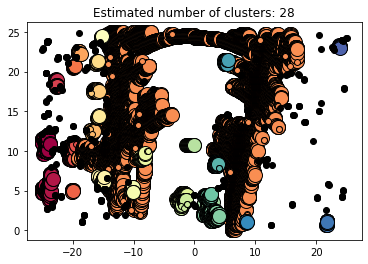

In [ ]:
cluster_SAR_pc(points_SAR)

### test

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler


# #############################################################################
# Generate sample data
centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(
    n_samples=750, centers=centers, cluster_std=0.4, random_state=0
)

X = StandardScaler().fit_transform(X)

# #############################################################################
# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)



print('db',db)
print('\n')
print('core_samples_mask',core_samples_mask)
print('\n')
print('labels',labels)
# print("Estimated number of clusters: %d" % n_clusters_)
# print("Estimated number of noise points: %d" % n_noise_)
# print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
# print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
# print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
# print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, labels))
# print(
#     "Adjusted Mutual Information: %0.3f"
#     % metrics.adjusted_mutual_info_score(labels_true, labels)
# )
# print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels))




# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()

# Labeling

In [ ]:
def label_SAR_pc(points_SAR, points_camera):
    clustered_cam_pc = cluster_camera_pc(points_camera)   #"classe": "cluster": {"centroid":[5,5], 'lim_points'[x_max,z_max] : [2.3,1.2], "points":[...]}
    print('clustered_cam_pc',clustered_cam_pc)
    AG_Plot_Labeling(clustered_cam_pc)
    points_SAR_labeled = {}
    points_SAR_unlabeled = points_SAR
    index = 0
    for points in points_SAR:
        xp = points[0]
        zp = points[1]
        for classe in clustered_cam_pc:
            points_SAR_labeled[classe] = {}
            for cluster in clustered_cam_pc[classe]:
                points_SAR_labeled[classe][cluster] = []
                xc = clustered_cam_pc[classe][cluster]['centroid'][0]
                zc = clustered_cam_pc[classe][cluster]['centroid'][1]
                x_lim = clustered_cam_pc[classe][cluster]['lim_points'][0]
                z_lim = clustered_cam_pc[classe][cluster]['lim_points'][1]
                #print(x_lim, z_lim)
                if abs(xc-xp) <= x_lim or abs(zc-zp) <= z_lim:    #if the sar points is in the range of the cluster, it belongs to the cluster
                    #print(points_SAR_labeled)
                    points_SAR_labeled[classe][cluster] += [points]

                    #print(points_SAR_unlabeled)
                    #np.delete(points_SAR_unlabeled, points)
        index += 1

    #points_SAR_labeled['unlabeled']['unlabeled_cluster'] = points_SAR_unlabeled
    print('points_SAR_labeled',points_SAR_labeled)
    AG_Plot_Labeling(points_SAR_labeled)
    

def AG_Plot_Labeling(points_SAR_labeled):
    for classe in points_SAR_labeled:
        for cluster in points_SAR_labeled[classe]:
            labeled_points = np.asarray(points_SAR_labeled[classe][cluster]['points'])
            X = labeled_points[:,0]
            Y = labeled_points[:,1]
            plt.plot(X,Y)
    plt.show()


# Combined Code

In [ ]:
frames=[]
video_radar = cv.VideoCapture(RADAR_VIDEO)
video_camera = cv.VideoCapture(CAMERA_VIDEO)
nb_frames_download_video = 100 #number of frames we desire for downloaded video


_, first_frame_radar = video_radar.read()
height, width, layers = first_frame_radar.shape
size = (width, height)
fourcc = cv.VideoWriter_fourcc(*'MJPG')
download_video = cv.VideoWriter('SARandCamera_pointcloud.avi', fourcc, 30.0, size)


#run through the frame 0
print('frame 0')

# Get SAR frame
points_SAR= GetThreshold_Binary(first_frame_radar)

# Get camera frame
video_camera.set(cv.CAP_PROP_POS_FRAMES, int(timestamp_map[i]))
_, curr_frame = video_camera.read()
nb_row, nb_col, rgb = first_frame_radar.shape

pc3darray = prediction_video(0, curr_frame, curr_frame)
points_camera = pc3darray

#run through the video until nb_frames_download_video
try:

    for i in range(1,nb_frames_download_video):
        print(i)
        
        # Get SAR frame
        _, frame_radar = video_radar.read()
        if not _: break
        points_SAR= GetThreshold_Binary(frame_radar) # 2D (X,Z)

        # Get camera frame
        video_camera.set(cv.CAP_PROP_POS_FRAMES, int(timestamp_map[i]))
        _, curr_frame = video_camera.read()
        pc3darray = prediction_video(i, points_camera, curr_frame)  #4D (X,Y,Z, class)
        
        # # Change to SAR frame
        # pointcloud = []
        # for j in range(len(pc3darray)):
        #   pointcloud.append(Cam_ref_2_Car_ref(pc3darray[j]))
        # points_camera = np.array(pointcloud)
        points_camera = pc3darray



        # Plot together
        Plot_Camera_with_SAR(points_SAR, points_camera)

        IPython.display.clear_output(wait=True)

        #add frame to the video of the top down view
        download_video.write(frames[i])

except KeyboardInterrupt:
    plt.close()
    print("Stream stopped.")

download_video.release()


# height, width, layers = frames[0].shape
# size = (width, height)
# fourcc = cv.VideoWriter_fourcc(*'MJPG')
# download_video = cv.VideoWriter('SARandCamera_pointcloud.avi', fourcc, 30.0, size)

# for i in range(len(frames)):
#     out.write(frames[i])
# out.release()

# Tests

In [13]:
thisdict = {
  "brand": "Ford",
  "model": "Mustang",
  "year": [1964],
  'prout':  {"brand": "Ford","model": "Mustang","year": 1964}
}

thisdict["year"] += [2018]
print(thisdict["year"])
print(thisdict["year"][0])
print(thisdict.keys())
print(thisdict['prout']["brand"])

[1964, 2018]
1964
dict_keys(['brand', 'model', 'year', 'prout'])
Ford
